In [3]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

sys.path.insert(0, '../libraries')
from mrcnn.config import Config
import mrcnn.utils as utils
import mrcnn.model as modellib
import mrcnn.visualize as visualize
from mrcnn.model import log
import mcoco.coco as coco
# import mextra.utils as extra_utils

%matplotlib inline
%config IPCompleter.greedy=True

HOME_DIR = 'F:\Mtech\Final_Project\Instance_project\Final_model\Model_dir'
DATA_DIR = os.path.join(HOME_DIR, "data/shapes")
WEIGHTS_DIR = os.path.join(HOME_DIR, "data/weights")
MODEL_DIR = os.path.join(DATA_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(WEIGHTS_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Importing Annotations

In [5]:
# NotebookApp.iopub_data_rate_limit=1000000.0
dataset_train = coco.CocoDataset()
dataset_train.load_coco(DATA_DIR, subset="shapes_train", year="2018")
dataset_train.prepare()

dataset_validate = coco.CocoDataset()
dataset_validate.load_coco(DATA_DIR, subset="shapes_validate", year="2018")
dataset_validate.prepare()

dataset_test = coco.CocoDataset()
dataset_test.load_coco(DATA_DIR, subset="shapes_test", year="2018")
dataset_test.prepare()

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


## Mask Generation

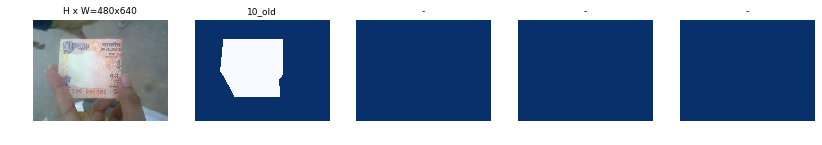

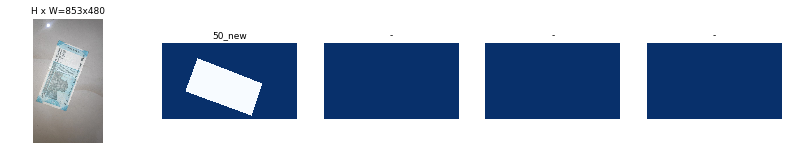

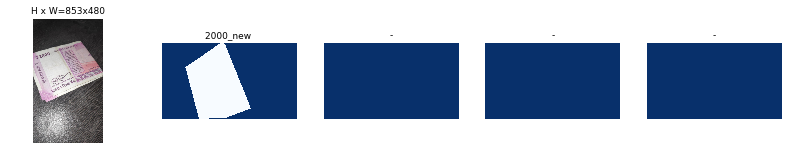

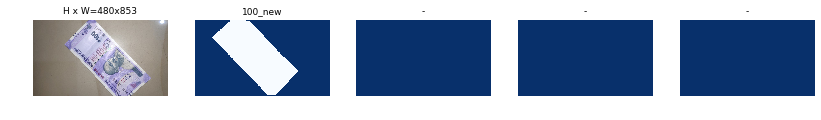

In [6]:
# # Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
# image_ids = [670]
# print(image_ids)

for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

[7]


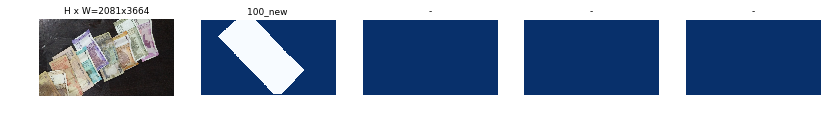

In [7]:
image = dataset_test.load_image(0)
mask, class_ids = dataset_train.load_mask(image_id)
print(class_ids)
visualize.display_top_masks(image, mask, class_ids, dataset_test.class_names)

In [8]:
image_size = 640
rpn_anchor_template = ( 2, 4, 8, 16, 32) # anchor sizes in pixels
rpn_anchor_scales = tuple(i * (image_size // 16) for i in rpn_anchor_template)

class ShapesConfig(Config):
    """Configuration for training on the shapes dataset.
    """
    NAME = "shapes"

    # Train on 1 GPU and 2 images per GPU. Put multiple images on each
    # GPU if the images are small. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 10  # background + 3 shapes (triangles, circles, and squares)

    # Use smaller images for faster training. 
    IMAGE_MAX_DIM = image_size
    IMAGE_MIN_DIM = image_size
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = rpn_anchor_scales

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 300

    STEPS_PER_EPOCH = 400

    VALIDATION_STEPS = STEPS_PER_EPOCH / 20
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                23
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MI

In [ ]:
MODEL_DIR

In [9]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1 
    IMAGES_PER_GPU = 1
    
inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)
print(model.mode)
print(model.find_last()[1])
model_path = model.find_last()[1]
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

W0729 23:30:22.322530 27448 module_wrapper.py:139] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 23:30:22.504662 27448 module_wrapper.py:139] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 23:30:22.514346 27448 module_wrapper.py:139] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 23:30:22.552602 27448 module_wrapper.py:139] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:2139: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0729 23:30:22.557590 27448 module_wrapper.py:139] From c:\program file

inference
F:\Mtech\Final_Project\Instance_project\Final_model\Model_dir\data/shapes\logs\shapes20200316T1634\mask_rcnn_shapes_0201.h5
Loading weights from  F:\Mtech\Final_Project\Instance_project\Final_model\Model_dir\data/shapes\logs\shapes20200316T1634\mask_rcnn_shapes_0201.h5


W0729 23:30:32.651343 27448 module_wrapper.py:139] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0729 23:30:32.652341 27448 module_wrapper.py:139] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0729 23:30:32.653340 27448 module_wrapper.py:139] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:203: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0729 23:30:34.234546 27448 module_wrapper.py:139] From c:\program files\python37\lib\site-packages\keras\backend\tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0729 23:30:34.234546 27448 module_wrapper.py:139] From c:\program files\pytho

## Testing Images

In [ ]:
dataset_train

image ID: coco.734 (1095) http://cocodataset.org/#explore?id=734
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  253.00000  uint8
anchors                  shape: (1, 102300, 4)        min:   -1.41643  max:    2.31627  float32
gt_class_id              shape: (1,)                  min:    8.00000  max:    8.00000  int32
gt_bbox                  shape: (1, 4)                min:  142.00000  max:  466.00000  int32
gt_mask                  shape: (640, 640, 1)         min:    0.00000  max:    1.00000  bool


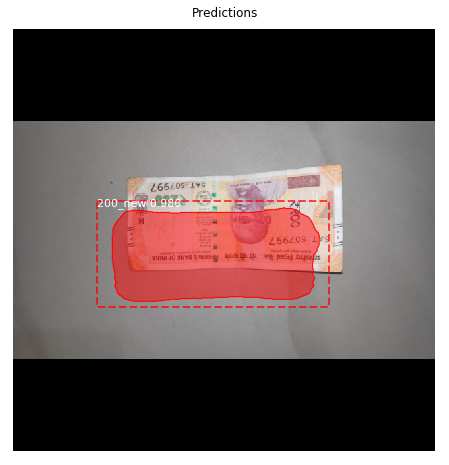

In [9]:
image_id = random.choice(dataset_train.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, config, image_id, use_mini_mask=False)
info = dataset_train.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_train.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
a = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


In [10]:
#@title
# !pip install gtts

## Classes

In [11]:
dataset_test.class_names

['BG',
 '10_old',
 '10_new ',
 '20_old',
 '50_old',
 '50_new ',
 '100_old',
 '100_new ',
 '200_new',
 '500_new ',
 '2000_new']

## Text to Speech

original_image           shape: (640, 640, 3)         min:    0.00000  max:  242.00000  uint8
image_meta               shape: (23,)                 min:    0.00000  max: 3664.00000  float64
gt_class_id              shape: (10,)                 min:    1.00000  max:   10.00000  int32
gt_bbox                  shape: (10, 4)               min:    3.00000  max:  568.00000  int32
gt_mask                  shape: (640, 640, 10)        min:    0.00000  max:    1.00000  bool


PermissionError: [Errno 13] Permission denied: 'E:\\Instance Segementation\\Final_model\\Model_dir\\static/1.png'

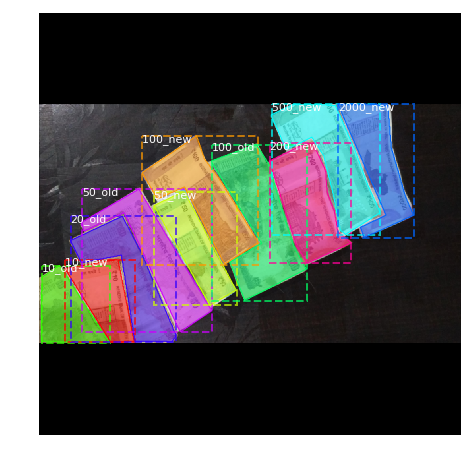

In [10]:
# print(dataset_test.class_names[0])
image_id = random.choice(dataset_test.image_ids)
# print(image_id)
for image_id in dataset_test.image_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
      modellib.load_image_gt(dataset_test, inference_config, 
                             image_id, use_mini_mask=False)
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                              dataset_test.class_names, figsize=(8, 8))
results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                              dataset_test.class_names, r['scores'], ax=get_ax())
# print("class_ids {}".format(r['class_ids']))
import re
detected = []
for cl in r['class_ids']:
#     print(dataset_test.class_names[cl])
    detected.append(dataset_test.class_names[cl])
  # print(dataset_test.class_names[r['class_ids'][0]])

detect_dict = {}
for i in range(1,len(dataset_test.class_names)):
#     print(dataset_test.class_names[i])
    detect_dict.update({dataset_test.class_names[i]:int(re.search(r'\d+', dataset_test.class_names[i]).group())})
    
import re
from gtts import gTTS 
from collections import Counter
col = []
fin_detec = []
detect_list = []

for dec in detected:
#     print(detect_dict[dec])
    col.append(" {}".format(detect_dict[dec]))
    
for i in range(len(col)):
    fin_detec.append(str(col[i])+" Rupees ")
a = dict(Counter(fin_detec))
for k,v in a.items():
#     print(v)
    if v == 1:
#         print("{} note of {}".format(v,k))
        detect_list.append("{} note of {}".format(v,k))
    else:
#         print("{} notes of {}".format(v,k))
        detect_list.append("{} notes of {}".format(v,k))
# print("counts {}".format(a))
# mytext = 'The image contains denominations of  '+ str(fin_detec)
# print("detect_list {}".format(detect_list))
mytext = " The image contains"+str(detect_list)
# print(mytext)
language = 'en'
myobj = gTTS(text=mytext, lang=language, slow=False) 
myobj.save("Notes4.mp3") 
# print("mp3 done")
os.system("mpg321 Notes4.mp3")

## Play

In [13]:
from pygame import mixer  # Load the popular external library

mixer.init()
mixer.music.load('Notes4.mp3')
mixer.music.play()

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## Stop

In [14]:
mixer.music.stop()

In [ ]:
# print(dataset_test.class_names[0])
image_id = random.choice(dataset_validate.image_ids)
print(image_id)
for image_id in dataset_validate.image_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
      modellib.load_image_gt(dataset_train, inference_config, 
                             image_id, use_mini_mask=False)
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                              dataset_train.class_names, figsize=(8, 8))
results = model.detect([original_image], verbose=1)
r = results[0]
print("results {}".format(r))
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                              dataset_train.class_names, r['scores'], ax=get_ax())
print("class_ids {}".format(r['class_ids']))
import re
detected = []
for cl in r['class_ids']:
#     print(dataset_test.class_names[cl])
    detected.append(dataset_train.class_names[cl])
  # print(dataset_test.class_names[r['class_ids'][0]])

detect_dict = {}
for i in range(1,len(dataset_train.class_names)):
    print(dataset_test.class_names[i])
    detect_dict.update({dataset_train.class_names[i]:int(re.search(r'\d+', dataset_train.class_names[i]).group())})
    
import re
from gtts import gTTS 
from collections import Counter
col = []
fin_detec = []
detect_list = []

for dec in detected:
    print(detect_dict[dec])
    col.append(" {}".format(detect_dict[dec]))
    
for i in range(len(col)):
    fin_detec.append(str(col[i])+" Rupees ")
a = dict(Counter(fin_detec))
for k,v in a.items():
    print(v)
    if v == 1:
        print("{} note of {}".format(v,k))
        detect_list.append("{} note of {}".format(v,k))
    else:
        print("{} notes of {}".format(v,k))
        detect_list.append("{} notes of {}".format(v,k))
print("counts {}".format(a))
mytext = 'The image contains denominations of  '+ str(fin_detec)
print("detect_list {}".format(detect_list))
mytext = " The image contains"+str(detect_list)
print(mytext)
language = 'en'
myobj = gTTS(text=mytext, lang=language, slow=False) 
myobj.save("Notes2.mp3") 
print("mp3 done")
os.system("mpg321 Notes2.mp3")

In [ ]:
import skimage
class_names = dataset_test.class_names
print("class names {}".format(class_names))
# IMAGE_DIR  = '/content/gdrive/My Drive/Final_model/deep-learning-explorer/data/shapes/shapes_test2018'
# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread('/content/gdrive/My Drive/Final_model/new_Indian_currency.jpeg')
# image = skimage.io.imread('E:\Instance Segementation\Final_model\deep-learning-explorer\data\shapes\shapes_validate2018/Mixed_original_IMG_20200313_092146.jpg_5b0cdb3c-188d-44dd-9495-a0d4f04ad39a.jpg')

image = skimage.io.imread('E:\Instance Segementation\Final_model\deep-learning-explorer\data\shapes\shapes_test2018/Mixed_original_IMG_20200313_092257.jpg_aa7468a0-1486-486e-9545-6ab4e87e7af3.jpg')
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
print("class_id: {}".format(r['class_ids']))
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'],figsize = (10,10))
print("class id: {}, class name: {} and score {}".format(r['class_ids'][0],class_names[r['class_ids'][0]],r['scores'][0]))
print(r['class_ids'])

## Average Precision

In [33]:
predictions =\
extra_utils.compute_multiple_per_class_precision(model, inference_config, dataset_test,
                                                 number_of_images=1, iou_threshold=0.4)
complete_predictions = []

for shape in predictions:
    complete_predictions += predictions[shape]
    print("{} ({}): {}".format(shape, len(predictions[shape]), np.mean(predictions[shape])))

print("--------")
print("Mean Average Precision MAP: {}".format(np.mean(complete_predictions)*100))

10_old (1): 1.0
10_new  (1): 1.0
20_old (1): 0.0
50_old (1): 0.0
50_new  (1): 1.0
100_old (1): 1.0
100_new  (1): 1.0
200_new (1): 1.0
500_new  (1): 1.0
2000_new (1): 1.0
--------
Mean Average Precision MAP: 80.0
